# В этом ноутбуке представлена первая гипотеза для оценки сходства датасетов, а также реализован метод сравнения датасетов в соответствии с первой гипотезой.

**Первая гипотеза** для метода оценки сходства датасетов:

_Сходство датасетов может быть связано со схожестью их текстового содержания, которое отражается в схожести часто встречающихся в датасетах слов._

----------------

Поэтому **метод сравнения датасетов** заключается в следующем:

Посчитать наиболее часто встречающиеся слова (исключив предлоги и артикли, которые могут встречаться часто, но при этом не оказывать существенного влияния на смысл текста) в каждом из датасетов и оставить, например, топ из _num_:=100 наиболее часто встречающихся слов. Для каждого датасета этот топ будет свой. Затем оценить, насколько похожи эти топы слов: 
для каждого слова из первого топа найти максимум similarity(рассматриваемое_фиксированное_слово_из_первого_топа, слово_из_второго_топа) по всем возможным значениям переменной слово_из_второго_топа. Проще говоря, для каждого слова из первого топа найти наиболее схожее слово из второго топа; после чего запомнить число, соответствующее степени их схожести. 

Для каждого слова из первого топа получится какое-то значение максимума similarity.  Следует сложить эти значения. Чем больше полученная сумма, тем более вероятно сходство датасетов.

Разумеется, можно брать _num_ равным не 100, а, например, 200 или 1000. Так как не ясно, какое значение _num_ даст наилучшие результаты, то следует провести вычисления для различных значений _num_.



In [ ]:
hotel_reviews = 'hotel reviews'
movie_reviews = 'movie reviews'
spam_sms = 'spam sms'
spam_emails = 'spam emails'

datasets_names = [hotel_reviews, movie_reviews, spam_sms, spam_emails]

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from collections import Counter
import re
import nltk
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='deep')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
flag_need_to_conduct_research_for_different_num_values = False  # флаг, соответствующий тому, следует ли считать датафреймы для различных значений num.
# Если выставить False, то это сэкономит время, результаты исследования будут взяты из Google Drive (куда записаны результаты ранее проведенного исследования).
flag_need_to_save_dataframes_to_google_drive = False  # флаг, соответствующий тому, следует ли сохранять в Google Drive полученные датафреймы.
# В первый раз его следует выставить True, в последнующем – допустимо выставить False.

In [ ]:
if flag_need_to_conduct_research_for_different_num_values:
    nltk.download('punkt')
    nltk.download('averaged_perceptron_tagger')
    import gensim.downloader as api
    wv = api.load('word2vec-google-news-300')

In [ ]:
def get_dataset_in_correct_form(dataset_name):
    if dataset_name == spam_sms:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/spam_sms.csv', encoding = "ISO-8859-1")
        df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
        df.columns = ['IS_SPAM', 'DATA_COLUMN']
        df['IS_SPAM'] = (df['IS_SPAM'] == 'spam').astype(int)
        df_positive = df[df['IS_SPAM']==1]
        df_negative = df[df['IS_SPAM']==0]
        # Тестовая выборка
        n_test = df_negative.shape[0] // 2
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 2
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 2
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 2
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    elif dataset_name == spam_emails:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/spam_emails.csv', encoding = "ISO-8859-1")
        df.drop(columns=['Unnamed: 0', 'label'], inplace=True)
        df.columns = ['DATA_COLUMN', 'IS_SPAM']
        df['DATA_COLUMN'] = df['DATA_COLUMN'].apply(lambda x: x.replace('\r\n', ' ').replace('\n', ' '))
        df_positive = df[df['IS_SPAM']==1]
        df_negative = df[df['IS_SPAM']==0]
        # Тестовая выборка
        n_test = df_negative.shape[0] // 2
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 2
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 2
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 2
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    elif dataset_name == hotel_reviews:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/tripadvisor_hotel_reviews.csv')
        df = df[df.Rating != 3]
        df['is_positive'] = (df['Rating'] >= 4).astype(int)
        df.drop(columns=['Rating'], inplace=True)
        df.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
        df_positive = df[df['LABEL_COLUMN']==1]
        df_negative = df[df['LABEL_COLUMN']==0]
        # Тестовая выборка
        n_test = (df_negative.shape[0] // 4) * 3
        df_negative_test = df_negative.tail(n_test)
        n_test = (df_positive.shape[0] // 20) * 3
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Обучающая выборка
        n_train = df_negative.shape[0] // 4
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 20
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])
    
    elif dataset_name == movie_reviews:
        df = pd.read_csv('/content/drive/MyDrive/data_for_colab/IMDB Dataset.csv')
        df['is_positive'] = (df['sentiment'] == 'positive').astype(int)
        df.drop(columns=['sentiment'], inplace=True)
        df.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
        df_positive = df[df['LABEL_COLUMN']==1]
        df_negative = df[df['LABEL_COLUMN']==0]
        # Для тестовой выборки берем последние 10% негативных отзывов и последние 10% позитивных отзывов
        n_test = df_negative.shape[0] // 10 # в оригинале df_negative.shape[0] // 10
        df_negative_test = df_negative.tail(n_test)
        n_test = df_positive.shape[0] // 10 # df_positive.shape[0] // 10
        df_positive_test = df_positive.tail(n_test)
        df_balanced_test = pd.concat([df_negative_test, df_positive_test])
        # Для обучающей выборки берем первые 2.5% из начала датасета.
        n_train = df_negative.shape[0] // 40 # в оригинале df_negative.shape[0] // 40
        df_negative_train = df_negative.head(n_train)
        n_train = df_positive.shape[0] // 40 # в оригианале df_positive.shape[0] // 40
        df_positive_train = df_positive.head(n_train)
        df_balanced_train = pd.concat([df_negative_train, df_positive_train])

    else:
        raise ValueError('Wrong dataset name')

    X_train = df_balanced_train['DATA_COLUMN'].squeeze()
    X_test = df_balanced_test['DATA_COLUMN'].squeeze()
    dataset_in_correct_form = pd.concat([X_train, X_test])
    return dataset_in_correct_form

In [ ]:
def is_good_tag(tag):
    # https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    # проверяем, что слово является прилагательным, существительным, наречием или глаголом
    return tag[:2] == 'JJ' or tag == 'NN' or tag == 'NNS' or tag[:2] == 'RB' or tag[:2] == 'VB'

def get_important_words(tagged):
    words_to_remove = ['is', 'am', 'are', 'i', 'he', 'she', 'it', 'was', 'were', 'have', 'has', 'had', 'ect', 'hou']
    important_words_to_return = []
    for word_and_tag in tagged:
        if is_good_tag(word_and_tag[1]) and (word_and_tag[0] not in words_to_remove) and len(word_and_tag[0]) > 2:
            important_words_to_return.append(word_and_tag[0])
    return important_words_to_return


def get_most_common_words_from_dataset(dataset, num=100):
    # убираем ненужное, считаем число встречаний каждого слова в counter
    TOKEN = re.compile(r'(?<!\S)[A-Za-z]+(?!\S)|(?<!\S)[A-Za-z]+(?=:(?!\S))')
    list_of_words_from_dataset = [word for item in dataset for word in re.findall(TOKEN, item)]
    counter = Counter(list_of_words_from_dataset)

    tokens = list(counter.keys())
    tagged = nltk.pos_tag(tokens)

    # оставим только наиболее значимые слова (в данном случае – существительные, глаголы, прилагательные и наречия)
    counter_with_important_words = Counter()
    for word in get_important_words(tagged):
        counter_with_important_words[word] = counter[word]
    # находим наиболее часто встречающиеся важные слова
    most_common_words = []
    for word_and_num_of_occurrences in counter_with_important_words.most_common(num):
        most_common_words.append(word_and_num_of_occurrences[0])
    return most_common_words



def get_similarity_of_lists_of_most_common_words(most_common_words_first_list, most_common_words_second_list):
    sum_of_similarities = 0

    for first_dataset_word in most_common_words_first_list:
        maximum_of_similarity = 0
        for second_dataset_word in most_common_words_second_list:
            # вычисляем сходство слов
            if first_dataset_word == second_dataset_word:
                current_similarity = 1
            elif first_dataset_word in wv.vocab and second_dataset_word in wv.vocab:
                current_similarity = wv.similarity(first_dataset_word, second_dataset_word)
            else:
                # слова различаются, и хотя бы одного из этих слов нет в словаре ––> в этом случае считаем сходство равным нулю
                current_similarity = 0
            # обновляем максимум
            maximum_of_similarity = max(maximum_of_similarity, current_similarity)
        sum_of_similarities += maximum_of_similarity
    return sum_of_similarities

In [ ]:
def calculate_datasets_similarity(first_dataset_name_local, second_dataset_name_local, num=100):

    first_dataset_in_correct_form = get_dataset_in_correct_form(first_dataset_name_local)
    second_dataset_in_correct_form = get_dataset_in_correct_form(second_dataset_name_local)

    most_common_words_of_first_dataset = get_most_common_words_from_dataset(first_dataset_in_correct_form, num)
    most_common_words_of_second_dataset = get_most_common_words_from_dataset(second_dataset_in_correct_form, num)

    result_similarity = get_similarity_of_lists_of_most_common_words(most_common_words_of_first_dataset, most_common_words_of_second_dataset)

    return result_similarity

In [ ]:
# flag_need_to_conduct_research_for_different_num_values = False  # Был выставлен ранее 

Если в ячейке выше поставить True, то в ячейке ниже будет запущено трудоемкое по времени вычисление результатов сравнения датасетов при различных num. Чтобы не проводить эти вычисления много раз, я (после проведения вычислений в первый раз) сохраняю результаты вычислений в Google Drive. При последующих запусках ноутбука я загружаю результаты вычислений из Google Drive.


In [ ]:
list_of_nums = [10, 20, 40, 80, 160, 320, 640, 900, 1280, 1800, 2560]

if flag_need_to_conduct_research_for_different_num_values:
    list_of_df_with_first_method_results = list()
    for num in list_of_nums:
        print('Research for num =', num, 'just started!')
        _i = 0
        cur_df_with_first_method_results = pd.DataFrame(columns=[hotel_reviews, movie_reviews, spam_sms, spam_emails])
        for cur_first_dataset in datasets_names:
            for cur_second_dataset in datasets_names:
                _i += 1
                print(_i, 'out of', len(datasets_names) ** 2, ':', "Please, be patient! Working on comparing", cur_first_dataset, 'with', cur_second_dataset)
                cur_df_with_first_method_results.loc[cur_first_dataset, cur_second_dataset] = calculate_datasets_similarity(cur_first_dataset, cur_second_dataset, num)
        list_of_df_with_first_method_results.append(cur_df_with_first_method_results)

    # сохраним в гугл диск полученные датафреймы
    for i in range(len(list_of_df_with_first_method_results)):
        cur_num = list_of_nums[i]
        list_of_df_with_first_method_results[i].to_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_with_num_' + str(cur_num) + '.csv')
else:
    list_of_df_with_first_method_results = [0] * len(list_of_nums)
    # загрузим из гугл-диска сохраненные датафреймы
    for i in range(len(list_of_df_with_first_method_results)):
        cur_num = list_of_nums[i]
        list_of_df_with_first_method_results[i] = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_with_num_' + str(cur_num) + '.csv')
        list_of_df_with_first_method_results[i].set_index('Unnamed: 0', inplace=True)
        list_of_df_with_first_method_results[i].index.names = [None]

In [ ]:
list_of_df_with_first_method_results[10]

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,2560.000000,1891.498019,1873.391097,1775.988819
movie reviews,1946.240497,2560.000000,1916.523626,1793.601138
spam sms,1788.308951,1792.895662,2560.000000,1720.540329
spam emails,1678.324324,1633.705862,1696.616522,2560.000000


In [ ]:
list_of_df_with_first_method_results[0]

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,10.000000,5.369096,4.672077,3.672123
movie reviews,5.907615,10.000000,5.322802,4.414048
spam sms,5.909298,5.994716,10.000000,4.910825
spam emails,2.468662,2.488150,2.654809,10.000000


Для удобства приведем датафреймы к схожему виду: поделим все значения в датафрейме на соответствующее этому датафрейму значение num и выразим полученное отношение в процентах:

In [ ]:
list_of_df_with_first_method_results_in_percent = []
for i in range(len(list_of_df_with_first_method_results)):
    list_of_df_with_first_method_results_in_percent.append(list_of_df_with_first_method_results[i].copy())
    for cur_first_dataset in datasets_names:
        for cur_second_dataset in datasets_names:
            list_of_df_with_first_method_results_in_percent[i].loc[cur_first_dataset, cur_second_dataset] *= 100 / list_of_nums[i]    
    if flag_need_to_save_dataframes_to_google_drive:
        list_of_df_with_first_method_results_in_percent[i].to_csv('/content/drive/MyDrive/data_for_colab/dataframes/first_approach/df_in_percent_with_num_' + str(list_of_nums[i]) + '.csv')


In [ ]:
list_of_df_with_first_method_results_in_percent[0]  # соответствует num = 10  

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,100.000000,53.690960,46.720768,36.721231
movie reviews,59.076150,100.000000,53.228018,44.140480
spam sms,59.092985,59.947162,100.000000,49.108251
spam emails,24.686621,24.881501,26.548091,100.000000


In [ ]:
list_of_df_with_first_method_results_in_percent[10]  # соответствует num = 2560  

,hotel reviews,movie reviews,spam sms,spam emails
hotel reviews,100.000000,73.886641,73.179340,69.374563
movie reviews,76.025019,100.000000,74.864204,70.062544
spam sms,69.855818,70.034987,100.000000,67.208607
spam emails,65.559544,63.816635,66.274083,100.000000


## Исследование эффективности метода для сходства датасетов в первом смысле (про перенос качества)

## Исследование эффективности метода для сходства датасетов во втором смысле

In [ ]:
def get_f1_score_values_from_df_from_additional_research(df_name: str):
    cur_df = pd.read_csv('/content/drive/MyDrive/data_for_colab/dataframes/additional_research/' + df_name + '.csv')
    cur_df.set_index('Unnamed: 0', inplace=True)
    cur_df.index.names = [None]
    return cur_df.f1_score.values


In [ ]:
def transform_name_of_dataset(dataset_name):
    if dataset_name in ['sms', 'emails']:
        return 'spam ' + dataset_name
    return dataset_name 

In [ ]:
list_of_dataset_names_with_underscore = ['hotel_reviews', 'movie_reviews', 'spam_sms', 'spam_emails']
list_of_pairs_considered = ['hotel_reviews_to_movie_reviews', 'hotel_reviews_to_emails', 'hotel_reviews_to_sms',
                            'movie_reviews_to_emails', 'movie_reviews_to_sms', 'sms_to_emails']
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()
    for pair_of_datasets in list_of_pairs_considered:
        # absolute quality difference: mean result
        df_name = 'df_absolute_quality_difference_when_switching_from_' + pair_of_datasets
        mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
        list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
        # absolute quality difference: median result
        median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
        list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

        # relative quality difference: mean result
        df_name = 'df_relative_quality_difference_in_percent_when_switching_from_' + pair_of_datasets
        mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
        list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
        # relative quality difference: median result
        median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
        list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)

        first_dataset_name, second_dataset_name = [transform_name_of_dataset(dataset_name.replace('_', ' ')) for dataset_name in pair_of_datasets.split('_to_')]

        method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset_name, second_dataset_name]
        list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)

    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)

In [ ]:
list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result

[0.07932257027161475,
 0.31019279339466616,
 0.42103923768940943,
 0.3925421750801581,
 0.4439187380457371,
 0.6043400657878801,
 0.5443010428959139,
 0.520272166220839,
 0.508605069823416,
 0.5781031614766409,
 0.5646604045778586]

In [ ]:
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result

[0.10477448442707434,
 0.3236702313627558,
 0.43859709712631595,
 0.4025379095995913,
 0.44926723408025876,
 0.6134306244022352,
 0.5512202177215442,
 0.5242720928824918,
 0.5150812916667644,
 0.5811839236750371,
 0.571928217179609]

In [ ]:
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result

[0.20060151491428868,
 0.3629861847281947,
 0.4299734893757614,
 0.3933613026638041,
 0.444021638479224,
 0.612420598986808,
 0.567462449189459,
 0.5372205887370025,
 0.5450477016792885,
 0.6079548356505914,
 0.6342989751459571]

In [ ]:
list_of_correlations_for_median_relative_quality_difference_and_first_method_result

[0.22372178339702678,
 0.3771446031628581,
 0.45197645464454406,
 0.40735590976545993,
 0.45240048826367435,
 0.623020081510504,
 0.5742665536719629,
 0.5411446514671787,
 0.5498113599069293,
 0.6075595834474903,
 0.633672547492217]

Построить графики для всез списков сразу, чтобы понять, какой индекс (то есть число num) лучше:

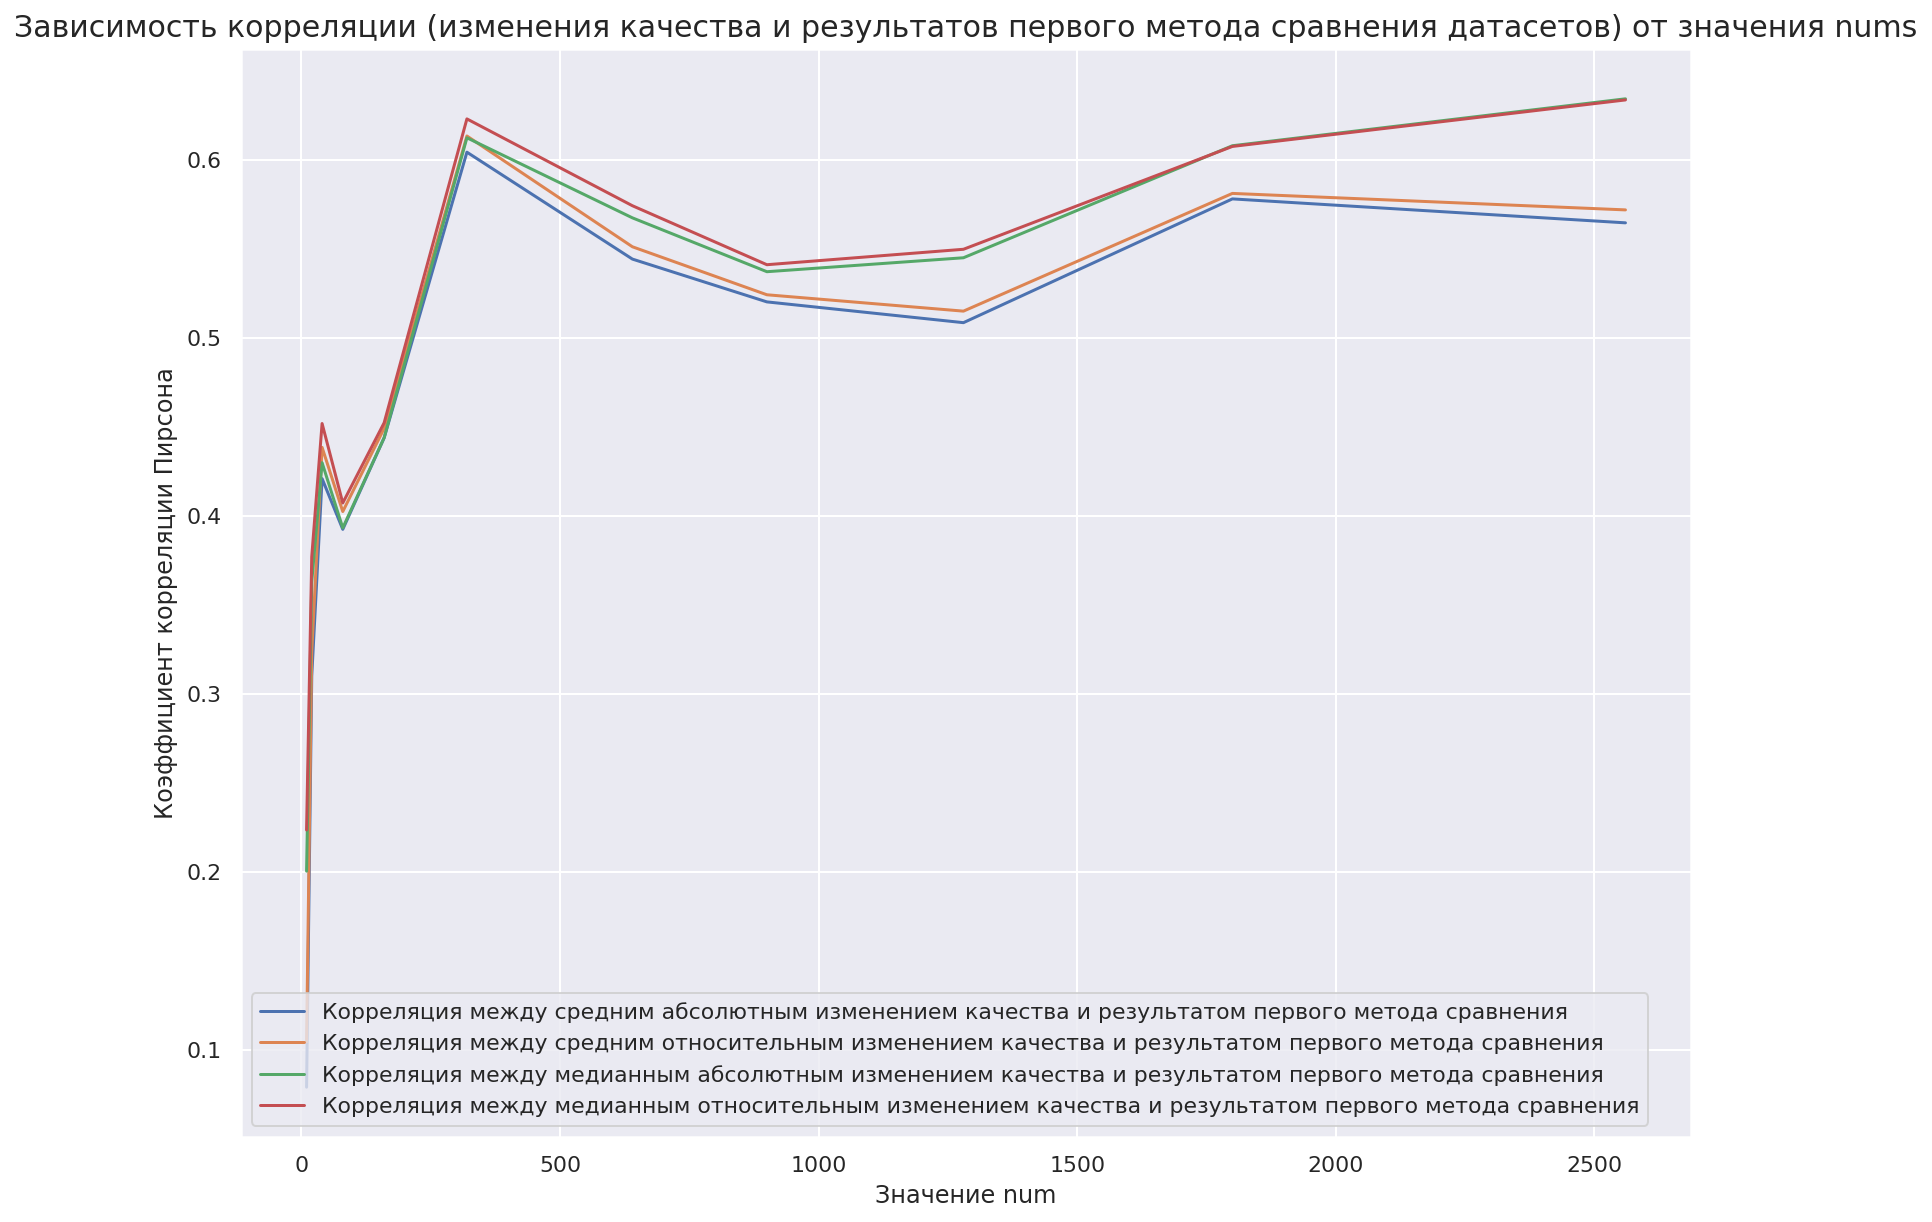

In [ ]:
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
         label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Зависимость корреляции (изменения качества и результатов первого метода сравнения датасетов) от значения nums", fontsize=15)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

In [ ]:
print(list_of_nums)

[10, 20, 40, 80, 160, 320, 640, 900, 1280, 1800, 2560]


# Вывод:
В целом, наилучшие результаты для сходства датасетов во втором смысле достигаются при *nums*=320 и при *nums*=2560.

------

Добавим переход в другую сторону и посмотрим ПО ВСЕМ ПАРАМ ДАТАСЕТОВ, какая будет корреляция:

In [ ]:
list_of_dataset_names_with_underscore = ['hotel_reviews', 'movie_reviews', 'spam_sms', 'spam_emails']

list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_absolute_quality_difference_and_first_method_result = list()
list_of_correlations_for_mean_relative_quality_difference_and_first_method_result = list()
list_of_correlations_for_median_relative_quality_difference_and_first_method_result = list()

for index_for_num in range(len(list_of_df_with_first_method_results_in_percent)):
    list_of_mean_f1_score_absolute_difference_values = list()
    list_of_median_f1_score_absolute_difference_values = list()
    list_of_mean_f1_score_relative_difference_values = list()
    list_of_median_f1_score_relative_difference_values = list()
    list_of_method_results = list()
    for first_dataset_name in list_of_dataset_names_with_underscore:
        for second_dataset_name in list_of_dataset_names_with_underscore:
            if first_dataset_name != second_dataset_name:
                pair_of_datasets = first_dataset_name + '_to_' + second_dataset_name
                pair_of_datasets = pair_of_datasets.replace('spam_', '')

                # absolute quality difference: mean result
                df_name = 'df_absolute_quality_difference_when_switching_from_' + pair_of_datasets
                mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
                list_of_mean_f1_score_absolute_difference_values.append(mean_f1_score_value)
                # absolute quality difference: median result
                median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
                list_of_median_f1_score_absolute_difference_values.append(median_f1_score_value)

                # relative quality difference: mean result
                df_name = 'df_relative_quality_difference_in_percent_when_switching_from_' + pair_of_datasets
                mean_f1_score_value = get_f1_score_values_from_df_from_additional_research(df_name).mean()
                list_of_mean_f1_score_relative_difference_values.append(mean_f1_score_value)
                # relative quality difference: median result
                median_f1_score_value = np.median(get_f1_score_values_from_df_from_additional_research(df_name))
                list_of_median_f1_score_relative_difference_values.append(median_f1_score_value)
                
                first_dataset_name_without_underscore = first_dataset_name.replace('_', ' ')
                second_dataset_name_without_underscore = second_dataset_name.replace('_', ' ')
                method_result = list_of_df_with_first_method_results_in_percent[index_for_num].loc[first_dataset_name_without_underscore, second_dataset_name_without_underscore]
                list_of_method_results.append(method_result)

    # absolute quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result.append(correlation)
    # absolute quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_absolute_difference_values)[0, 1]
    list_of_correlations_for_median_absolute_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: mean result
    correlation = np.corrcoef(list_of_method_results, list_of_mean_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_mean_relative_quality_difference_and_first_method_result.append(correlation)
    # relative quality difference: median result
    correlation = np.corrcoef(list_of_method_results, list_of_median_f1_score_relative_difference_values)[0, 1]
    list_of_correlations_for_median_relative_quality_difference_and_first_method_result.append(correlation)




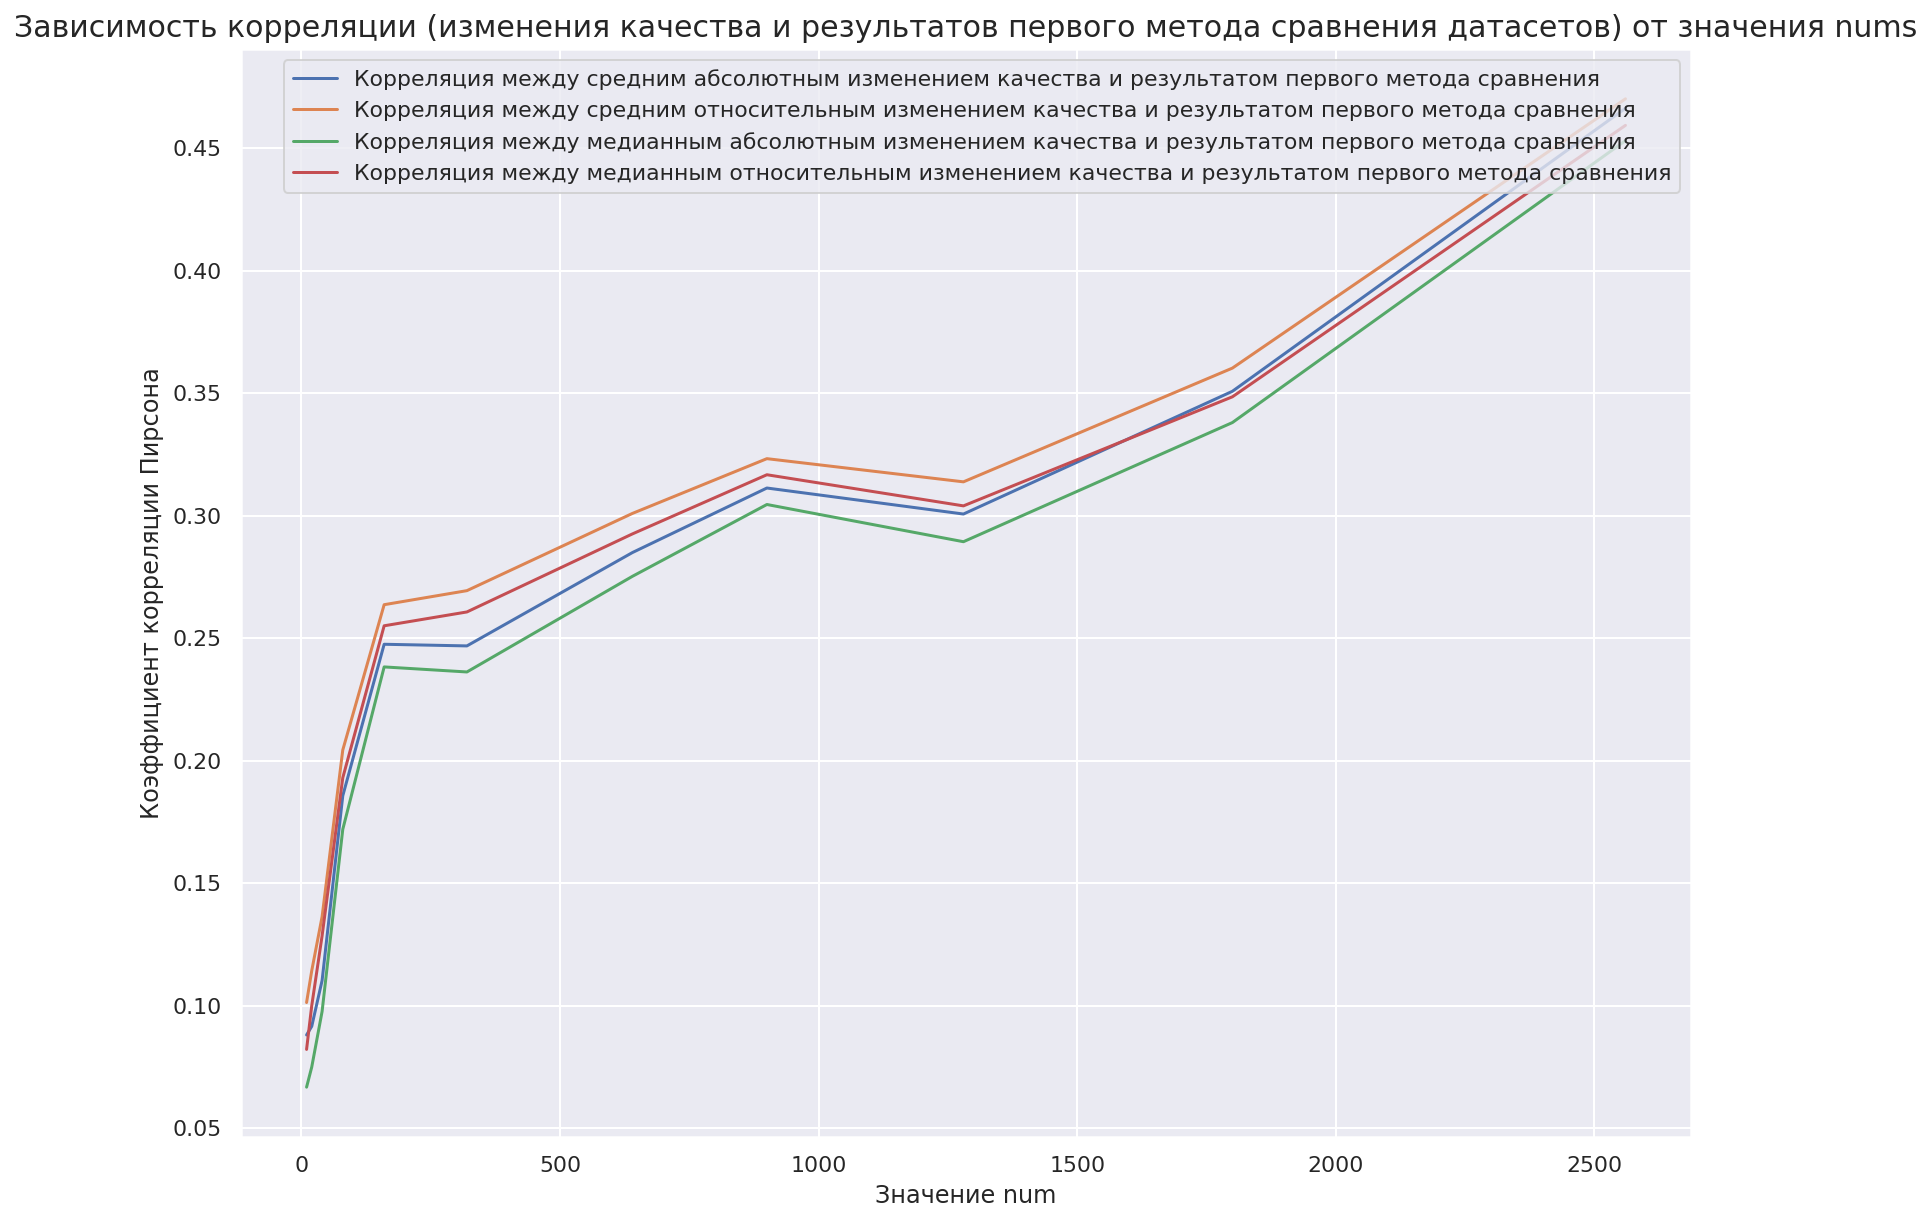

In [ ]:
plt.rcParams["figure.figsize"] = (13, 10)
plt.plot(list_of_nums, list_of_correlations_for_mean_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между средним абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_mean_relative_quality_difference_and_first_method_result, 
         label="Корреляция между средним относительным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_absolute_quality_difference_and_first_method_result, 
         label="Корреляция между медианным абсолютным изменением качества и результатом первого метода сравнения")
plt.plot(list_of_nums, list_of_correlations_for_median_relative_quality_difference_and_first_method_result,
         label="Корреляция между медианным относительным изменением качества и результатом первого метода сравнения")
plt.title("Зависимость корреляции (изменения качества и результатов первого метода сравнения датасетов) от значения nums", fontsize=15)
plt.xlabel("Значение num")
plt.ylabel("Коэффициент корреляции Пирсона")
plt.legend()
plt.show()

**Вывод:** корреляция средняя. 